# CMIP7 Diagnostics in CICE5



As far as possible, the default configurations of ACCESS-ESM1.6 output diagnostics in 
the format requested for CMIP7 as native output.

### Masking over time and space

Intrinsic and extrinsic

`sitimefrac`

This has the impact that sometimes diagnostics between the sea ice and ocean may have the
same descriptions but be masked differently.

e.g. 

*Water Flux into Sea Water Due to Sea Ice Thermodynamics* 
 - siflfwbot is masked only where sea_ice (in time and space)
 - fsithem is in all wet cells
 both are reported in `kg m-2 s-1` but the areas and time they are calculated for are different

*Thickness*
- sivol is Sea-Ice Volume per Area, calculated using grid cell area
- sithick is a true Sea-Ice Thickness (alternative description would be Sea Ice Volume per Sea Ice Area)
both are repored in `m`

### Load Data

To demonstrate some concepts, we are going to load some data.

TO-DO: Re-run when there is published data available

In [2]:
PATH = "/g/data/tm70/as2285/experiments/esm1.6-cmip7_vars-2025.10.08/"

import xarray as xr
from matplotlib import pyplot as plt

In [3]:
daily_ds = xr.open_mfdataset(f'{PATH}/output00*/ice/iceh-1daily-mean_184*.nc')

monthly_ds = xr.open_mfdataset(f'{PATH}/output00*/ice/iceh-1monthly-mean_184*.nc')

ds = monthly_ds.isel(time=0)

In [4]:
sh = {'slice':slice(0,150), 'name':'sh', 'title':'Antarctic'}
nh = {'slice':slice(150,None), 'name':'nh', 'title':'Arctic'}

### Mass / Concentrations / Age

siage was reset to 0 at the start of the pi_control run ?

We use [fixed densities](https://github.com/ACCESS-NRI/cice5/blob/62dcb7ee19f6e0a71d4b8e3e548b8cece0b930cf/drivers/access/ice_constants.F90#L22-L29) for sea ice, sea water and snow:

In [5]:
rhos      = 330.0  # density of snow (kg/m^3)
rhoi      = 917.0  # density of ice (kg/m^3)
rhow      = 1026.0 #density of seawater (kg/m^3)

You can also check these through the diagnostics, for example:

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/dask/_task_spec.py:764: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


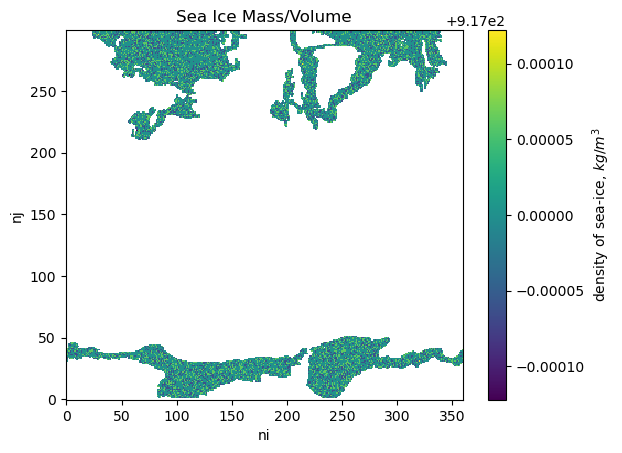

In [6]:
(ds.simass/ds.sivol).plot(cbar_kwargs={'label':'density of sea-ice, $kg/m^3$'})
plt.title('Sea Ice Mass/Volume')
plt.show()

Sea ice freeboad, thickness and snow thickness should balance to rounding error following Archimedes
principal of buoyancy. 
On the LHS we have mass of snow and sea ice together. 
On the RHS we have mass of sea water displaced, calculated as the volume of sea ice below the surface multiplied by density of water

$sithick*rhoi+sisnthick*rhos = (sithick-sifb)*rhow$

sithick, sisnthick, sifb are all weighted by siconc in time, and presented as $kg/m^2$

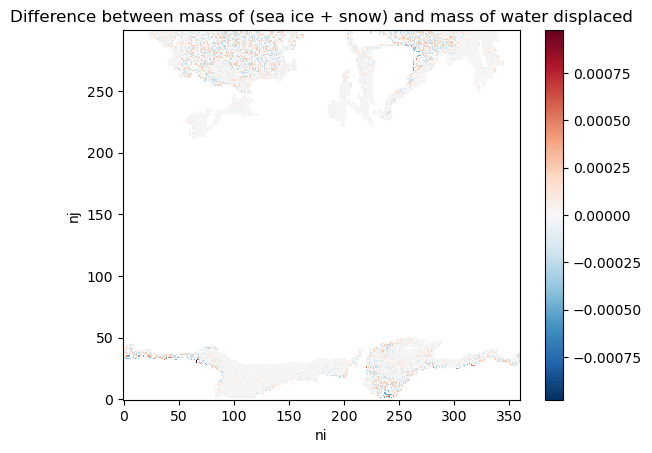

In [7]:
(ds.sithick*rhoi+ds.sisnthick*rhos-(ds.sithick-ds.sifb)*rhow).plot()
plt.title('Difference between mass of (sea ice + snow) and mass of water displaced')
plt.show()

Mass and volume terms balance too: 


- $ sivol*rhoi = simass $  (sivol and simass are extrinsic)
- $ sisnthick*rhos = sisnmass $. (sisnthick and sisnmass are intrinsic)
- $ sivol = sithick*siconc $ <!-- I am confused about why this is true, as sithick is intrinsic-->


We use [fixed salinity](https://github.com/ACCESS-NRI/access-esm1.6-configs/blob/c150adbad53b3dc8ed4079fe2136cbb767fa0a63/ice/cice_in.nml#L46) 
for sea ice of 4 g/kg. Therefore: 

- $ sisalt = simass * 0.004 $

In [ ]:
### Heat Fluxes

There is no process for penetrating shortwave through sea ice (`sifswdbot` is zero). 
The sea ice thermodynamic model is zero-layer, so top and bottom conductive heat flux are equal (`siflcondtop = siflcondbot`)

There is heat flux no diagnostic for frazil melt potential but there is a diagnostic for
_Sea-Ice Mass Change Through Growth in Supercooled Open Water (Frazil)_ (`sidmassgrowthwat`)

We report these on the atmosphere grid as well:

```
sifllattop s03i234
sifllwdtop s02i501
sifllwutop s03i531
siflsenstop s03i533
siflswdtop s01i501
siflswutop s01i503
```

To-do:
- check if these are masked by sea ice area

In [ ]:
### Salt / Water Fluxes

sipr		Rainfall Rate over Sea Ice
siflfwbot		Freshwater Flux from Sea Ice

### Dynamics

As 

By convention - dynamics are reported on the native grid (e.g. velocity and speed) but on the a-grid where a
quanity combines a-grid and b-grid variables (e.g. masstransport)


On the A-grid
| Var Name| Description|
|----|:----|
|sidmassdyn	    |Sea-Ice Mass Change from Dynamics|
|sidmasstranx	|X-Component of Sea-Ice Mass Transport|
|sidmasstrany	|Y-Component of Sea-Ice Mass Transport|

`sidmassdyn` is the change in mass in a cell due to dynamics. Sea ice mass transport (`sidmasstran`)
is calculated as a rate of transport through the right (positive x) and top (positive y) edge of the cell.
The `sidmasstran` terms are calculated as $velocity * celledgelength*rhoi$, where velocity is a mean of the 
velocity in the relevant corners of the cell to reflect a velocity in the middle of the edge.

These quantities are all reported on the b-grid / corner point :

| Var Name| Description|
|----|:----|
|sicompstren		|	Compressive Sea Ice Strength |
|sistrxdtop		|	X-Component of Atmospheric Stress on Sea Ice |
|sistrxubot		|	X-Component of Ocean Stress on Sea Ice |
|sistrydtop		|	Y-Component of Atmospheric Stress on Sea Ice |
|sistryubot		|	Y-Component of Ocean Stress on Sea Ice |

Sea ice mass change from dynamics sums to zero for each hemisphere as sea ice mass is conserved during sea ice dynamics processes.

Snow mass is also conserved by sea ice dynamics, however `sisndmassdyn` does not sum to zero as the diagnostic is intrinsic.

(to-do : should we save dvsdtd to confirm ?)

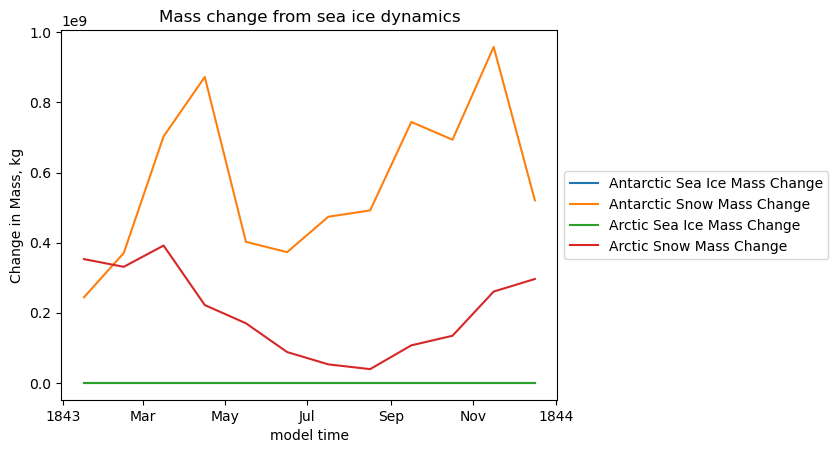

In [61]:
for hemi in [sh,nh]:
    (monthly_ds.sidmassdyn*monthly_ds.tarea).isel(nj=hemi['slice']).sum(['ni','nj']).plot(label = hemi['title']+' Sea Ice Mass Change')
    (monthly_ds.sisndmassdyn*monthly_ds.tarea).isel(nj=hemi['slice']).sum(['ni','nj']).plot(label = hemi['title']+' Snow Mass Change')
plt.ylabel('Change in Mass, kg')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Mass change from sea ice dynamics')
plt.show()

### Thermodynamics

Sea-Ice Heat Content (`sihc`)
Snow Heat Content (`sisnhc`) 

Evaporation terms are calculated within the atmosphere model, on the atmosphere grid,
these are conservatively regrid to the sea ice grid. Conservative regridding leads
to sign changes in some cells, leading to sea ice or snow mass gain due to evaporation/sublimation

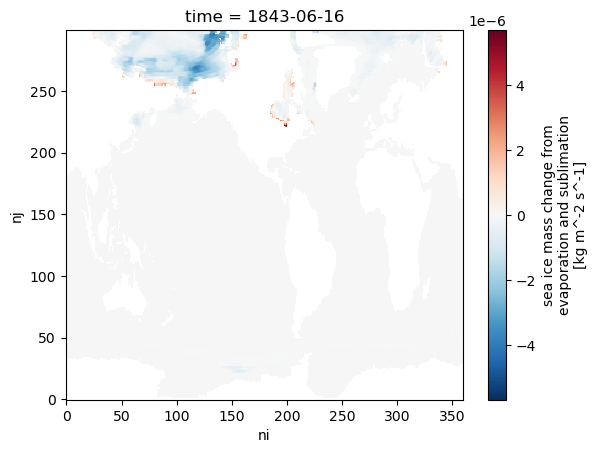

In [46]:
monthly_ds.sidmassevapsubl.isel(time=5).plot()

Diagnostics for Sea ice mass change are extrinsic

| Var Name| Description|
|----|:----|
| sidmassth |		Sea-Ice Mass Change from Thermodynamics |

is the sum of 

| Var Name| Description|
|----|:----|
|sidmassgrowthbot|	Sea-Ice Mass Change Through Basal Growth |
|sidmassgrowthsi|		Sea-Ice Mass Change Through Snow-to-Ice Conversion |
|sidmassgrowthwat|	Sea-Ice Mass Change Through Growth in Supercooled Open Water (Frazil) |
|sidmassmeltbot|		Sea-Ice Mass Change Through Bottom Melting |
|sidmassmeltlat|		Sea-Ice Mass Change Through Lateral Melting|
|sidmassmelttop|	    Sea-Ice Mass Change Through Surface Melting|
|sidmassevapsubl|	Sea-Ice Mass Change Through Evaporation and Sublimation|

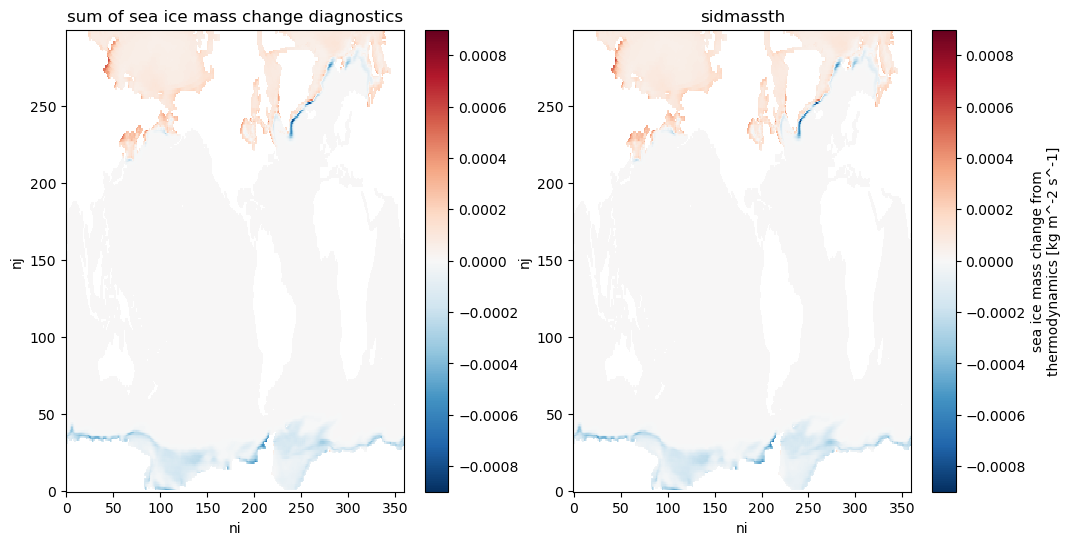

In [38]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
( ds.sidmassgrowthwat
 + ds.sidmassgrowthbot
 + ds.sidmassgrowthsi
 + ds.sidmassevapsubl
 - ds.sidmassmelttop
 - ds.sidmassmeltbot
 - ds.sidmassmeltlat
 ).plot()
plt.title('sum of sea ice mass change diagnostics')

plt.subplot(1,2,2)
ds.sidmassth.plot()
plt.title('sidmassth')
plt.show()


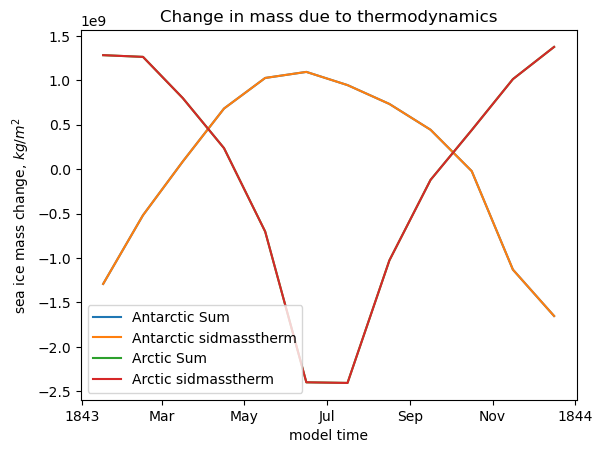

In [43]:
for hemi in [sh,nh]:
    ((   monthly_ds.sidmassgrowthwat
     + monthly_ds.sidmassgrowthbot
     + monthly_ds.sidmassgrowthsi
     + monthly_ds.sidmassevapsubl
     - monthly_ds.sidmassmelttop
     - monthly_ds.sidmassmeltbot
     - monthly_ds.sidmassmeltlat
    )*monthly_ds.tarea).isel(nj=hemi['slice']).sum(['ni','nj']).plot(label = hemi['title']+' Sum')
    (monthly_ds.sidmassth*monthly_ds.tarea).isel(nj=hemi['slice']).sum(['ni','nj']).plot(label = hemi['title']+' sidmasstherm')

plt.title('Change in mass due to thermodynamics')
plt.ylabel('sea ice mass change, $kg/m^2$')
plt.legend()
plt.show()

There is no overall diagnostic for snow mass rate of change, however these sum of the following diagnostics should be zero for each hemisphere over a long run
if there is no snow accumulating: (TO-DO: add example, is this correct? vars are intrinsic)

| Var Name| Description|
|----|:----|
|sisndmassmelt		|Snow Mass Rate of Change Through Melt|
|sisndmasssi		|    Snow Mass Rate of Change Through Snow-to-Ice Conversion|
|sisndmasssnf		|Snow Mass Change Through Snowfall|
|sisndmasssubl		|Snow Mass Rate of Change Through Evaporation or Sublimation|

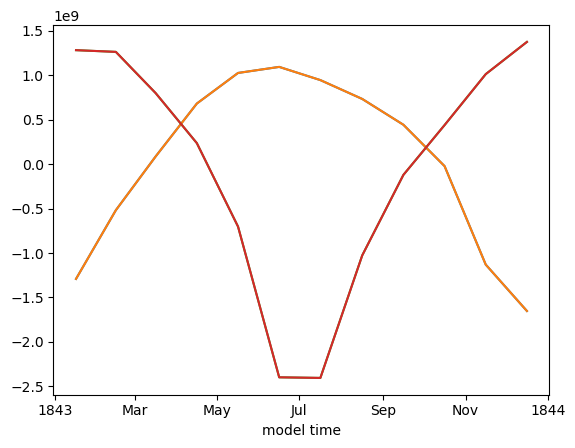

In [54]:
for hemi in [sh,nh]:
    ((monthly_ds.sidmassdyn+monthly_ds.sidmassth)*monthly_ds.tarea).isel(nj=hemi['slice']).sum(['ni','nj']).plot(label = hemi['title']+' Sum')
    ((monthly_ds.sidmassth)*monthly_ds.tarea).isel(nj=hemi['slice']).sum(['ni','nj']).plot(label = hemi['title']+' Sum')


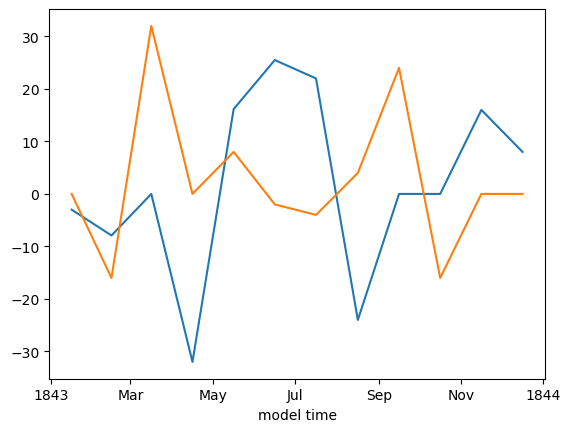

In [52]:
for hemi in [sh,nh]:
    (monthly_ds.sidmassdyn*monthly_ds.tarea).isel(nj=hemi['slice']).sum(['ni','nj']).plot(label = hemi['title']+' Sum')


|sisndmassdyn		|Snow Mass Rate of Change Through Advection by Sea-Ice Dynamics|

In [ ]:
Not reported as not a process in access-esm1.6:
sisndmasswind		Snow Mass Rate of Change Through Wind Drift of Snow

Variable for snow are generally masked for when there is sea ice (i.e. intrinsic)

In CICE, Snow-to-Ice conversion only occurs when the weight of the snow pushes the sea ice below the water level 
(i.e. freeboard is negative) and the mass of snow is directly converted to the mass of sea ice. The process is adiabiatic,
there is no energy exchanged in the process. However sidmassgrowthsi is greater than sisndmasssi as sidmassgrowthsi is extrinsic and sisndmasssi is intrinsic.

Similarly, `siflfwbot` doesn't balance with the relevant `sidmass` terms, as `siflwbot` is intrinsic.




### Hemispheric Scalars

Diagnostics which do not have a spatial coordinate are only available via post-processings:

siareaacrossline			sea_ice_area_transport_across_line	Sea-Ice Area Flux Through Straits
simassacrossline			sea_ice_transport_across_line	Sea-Ice Mass Flux Through Straits
siarean		sea_ice_area	Sea-Ice Area North
siareas		sea_ice_area	Sea-Ice Area South
siextentn		Sea-Ice Extent North
siextents		Sea-Ice Extent South
sisnmassn		surface_snow_mass	Snow Mass on Sea Ice North
sisnmasss		surface_snow_mass	Snow Mass on Sea Ice South
sivoln		sea_ice_volume	Sea-Ice Volume North
sivols		sea_ice_volume	Sea-Ice Volume South

SyntaxError: unterminated string literal (detected at line 21) (1000282888.py, line 21)